<a href="https://colab.research.google.com/github/norgel/food-sales-predictions/blob/main/Project_1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 1 Final

Submitted to GitHub

## Nicholas Orgel

### 09/21/2022

In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, \
OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Run unfiltered 'sales_predictions.csv'
df = pd.read_csv('/content/sales_predictions.csv')
pd.read_csv('/content/sales_predictions.csv')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [4]:
# Make a copy of the data
ml_df = df.copy()

In [5]:
ml_df = ml_df.drop(columns = ['Outlet_Size',
                      'Item_Identifier',
                      'Outlet_Type',
                      'Outlet_Identifier'])

In [6]:
ml_df.isna().sum()
# Item_Weight 1463

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Item_Outlet_Sales               0
dtype: int64

In [7]:
ml_df.duplicated().sum()
# No Duplicates

0

### Drop Duplicates and Fix Inconsistencies

In [8]:
iw_mean = ml_df['Item_Weight'].mean()
iw_mean.round(2)
# 12.86

12.86

In [9]:
# Filling in missing values for Item_Weight
ml_df['Item_Weight']= ml_df['Item_Weight'].fillna(iw_mean)

In [10]:
ml_df.isna().sum()
# Item_Weight & Outlet_Size are now 0

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Item_Outlet_Sales            0
dtype: int64

In [11]:
# Fixing Inconsistencies with column 'Item_Fat_Content'
ml_df['Item_Fat_Content'] = ml_df['Item_Fat_Content'].replace('LF', 'Low Fat')
ml_df['Item_Fat_Content'] = ml_df['Item_Fat_Content'].replace('low fat', 'Low Fat')
ml_df['Item_Fat_Content'] = ml_df['Item_Fat_Content'].replace('reg', 'Regular')
ml_df['Item_Fat_Content'].value_counts()


Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- [x] Double checking duplicates and missing values are still 0


In [12]:
ml_df.duplicated().sum()

0

In [13]:
ml_df.isna().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Item_Outlet_Sales            0
dtype: int64

Assigning the target (y) value ['Item_Outlet_Sales'] & features (X) 

In [14]:
y=ml_df['Item_Outlet_Sales']
X=ml_df.drop(['Item_Outlet_Sales'], axis=1)

Perform a Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean') # Numeric Columns
freq_imputer = SimpleImputer(strategy='most_frequent') # Categorical Columns
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

In [17]:
# Creating Pipelines
num_pipeline = make_pipeline(mean_imputer, scaler)
cat_pipeline = make_pipeline(freq_imputer, ohe)
# Creating Tuples
num_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)

In [18]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4630efe710>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4630efe6d0>)])

# New Tasks:

## 1. Use a linear regression model to predict sales.

- [x] Build a linear regression model
- [x] Evaluate the performance of the model based on r^2.
- [x] Evaluate the performance of the model based on rmse.
---
## 2. Build a regression tree model to predict sales.

- [x] Build a simple regression tree model.
- [x] Compare the performance of the model based on r^2.
- [x] Compare the performance of the model based on rmse.

Build a linear regression model

In [19]:
# Instantiate scaler and model
scaler = StandardScaler()
lin_reg = LinearRegression()

# Create Pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

# Fit Pipeline to Training Data
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4630efe710>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4630efe6d0>)])),
                ('linearregression', LinearRegression())])

In [20]:
# Create Model Predictions for Training & Testing Data
train_pred = lin_reg_pipe.predict(X_train)
test_pred = lin_reg_pipe.predict(X_test)

In [21]:
# Evaluate Model Performance Based on r^2
# Scikit-Learn Method
train_r2 = np.corrcoef(y_train, train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, test_pred)[0][1]**2

print(f'Model Training R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Training R2: 0.36316196057545613
Model Testing R2: 0.3476853946238407


In [22]:
# Evaluating Model Performance Based on RMSE
# Python Method
train_RMSE = np.sqrt(np.mean(np.abs(train_pred - y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(test_pred - y_test)**2))

print(f'Model Training RMSE: {train_RMSE}')
print(f'Model Testing RMSE: {test_RMSE}')

Model Training RMSE: 1372.8437505331644
Model Testing RMSE: 1343.389664001148


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

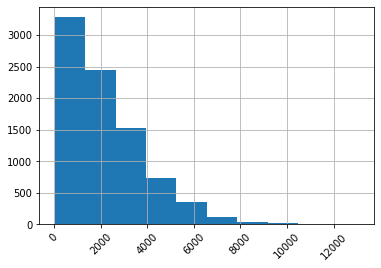

In [41]:
df['Item_Outlet_Sales'].hist();
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks(rotation = 45);


---

## 2. Build a regression tree model to predict sales.

- [x] Build a simple regression tree model.
- [x] Compare the performance of the model based on r^2.
- [x] Compare the performance of the model based on rmse.

In [23]:
from sklearn.tree import DecisionTreeRegressor

In [24]:
dec_tree = DecisionTreeRegressor(random_state=42)

In [25]:
# Make a new pipeline for decision tree regressor
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

In [26]:
# Fit the Model using the Training Data (X)
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4630efe710>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4630efe6d0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [27]:
# Predict target values for training and testing set
train_predictions = dec_tree_pipe.predict(X_train)
test_predictions = dec_tree_pipe.predict(X_test)

In [28]:
# Evaluate the model (default metric is R2, can be obtained using the .score() method)
train_score = dec_tree_pipe.score(X_train, y_train)
test_score = dec_tree_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.1961778490335483


In [30]:
train_RMSE = np.sqrt(np.mean(np.abs(train_predictions - y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(test_predictions - y_test)**2))
print(train_RMSE)
print(test_RMSE)

0.0
1489.203497831083


## Overall, I would choose a linear regression model because the train/test data is closer together than compared to the regression tree model.